# Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import geopandas as gpd
import pandas as pd
import os
import re

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [3]:
pd.set_option('display.max_rows', None)
pd.options.display.max_rows = 100

In [4]:
curr_path = os.getcwd()
directory = curr_path + '\\2018\\2018_srautai\\'
print(directory)

C:\Users\Antaniukas\Desktop\Vilnius traffic data\traffic\2018\2018_srautai\


# Functions

In [5]:
def get_code_main(row):
    return re.findall(r'\d+', row['Name'])[1]

def get_code_coordinates(row):
    return re.findall(r'\d+', row['Node'])[0]

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

def format_x(row):
    return float(str(row['x']).replace(',','.'))
    
def format_y(row):
    return float(str(row['y']).replace(',','.'))

def color_producer(val):
    if val < 109.687623:
        return 'forestgreen'
    elif val < 141.277798:
        return 'darkorange'
    elif val < 183.130633:
        return 'darkred'
    else:
        return 'darkblue'
    
def get_year(row):
    return row['Time'].year

def get_month(row):
    return row['Time'].month

def get_day(row):
    return row['Time'].day

def get_week_day(row):
    return row['Time'].weekday()

def get_week_day_1(row):
    return row['Date'].weekday()

def get_hour(row):
    return row['Time'].hour

def date(row):
    return '2018-{}-{}'.format(int(row['Month']), int(row['Day']))

def weekends(row):
    if row['Week day'] in [5,6]:
        return 1 
    else:
        return 0

# Load data

In [146]:
df_main = pd.DataFrame()
for file in os.listdir(directory):
    df_concat = pd.read_csv(directory + file, sep=';')
    df_main = pd.concat([df_main, df_concat], ignore_index=True)

df_coordinates = pd.read_excel('Sankryzos_koordinatės.XLSX', sheet_name='Lapas1')

In [147]:
df_main.head()

In [148]:
df_coordinates

# Data aggregations

## Get crossroads codes

To get each crossroad coordinates on main data conntaining dataframe need to extract each crossroad codes on which later will be joined dataframe with all corssroads coordinates

In [149]:
df_main['Code'] = df_main.apply(get_code_main, axis=1)

## Get corssroads coordinates

Extracting each crossroad codes for later joining on that

In [150]:
df_coordinates['Code'] = df_coordinates.apply(get_code_coordinates, axis=1)

## Save intermediate dataframes to csv

Saving semi-aggregated dataframes into csv to avoid doing the same procedures several time because it takes quite a while

In [151]:
df_coordinates.to_csv('coordinates_data_with_codes.csv')
df_main.to_csv('main_data_with_codes.csv')

## Datetime aggregations

First we need to convert *Time* columns to datetime type and then extract components like year, month, day, hour for later filtering

In [4]:
df_main = pd.read_csv('main_data_with_codes.csv')

In [5]:
df_main['Time'] = pd.to_datetime(df_main['Time'])

In [6]:
df_main['Month'] = df_main.apply(get_month, axis=1)

In [7]:
df_main['Day'] = df_main.apply(get_day, axis=1)

In [9]:
df_main['Hour'] = df_main.apply(get_hour, axis=1)

Getting week day from *Time* column to filter later by week day and procede analysis based on them ([5,6] - weekend, [7,1,2,3,4] - working days)

In [8]:
df_main['Week day'] = df_main.apply(get_week_day, axis=1)

## Save intermediate dataframes to csv

In [ ]:
df_main.to_csv('main_data_with_codes_and_dates.csv')

## Join tables

In [44]:
df = df_main.merge(df_coordinates, on='Code', how='left')

## Save intermediate dataframes to csv

In [45]:
df.to_csv('main_data_with_codes_dates_and_coordinates.csv')

# Dataframe

In [156]:
df.iloc[:,2:].head()

,Name,Time,vol_orig,occ_orig,spd_orig,vol_proc,occ_proc,spd_proc,Code,Month,Day,Week day,Hour,Unnamed: 0_y,Node,x,y
0,ig11FD101_D1,2018-01-04 01:00:00,58.033333,0.325278,0.0,58.033333,0.325278,43.757286,101,1,4,3,1,9.0,K101 Žygimantų-Goštauto-Vilniaus,"25,27987","54,690814"
1,ig11FD101_D1,2018-01-04 02:00:00,46.977780,0.349722,0.0,46.977780,0.349722,41.199390,101,1,4,3,2,9.0,K101 Žygimantų-Goštauto-Vilniaus,"25,27987","54,690814"
2,ig11FD101_D1,2018-01-04 03:00:00,24.022223,0.150278,0.0,24.022223,0.150278,39.411720,101,1,4,3,3,9.0,K101 Žygimantų-Goštauto-Vilniaus,"25,27987","54,690814"
3,ig11FD101_D1,2018-01-04 04:00:00,9.000000,0.000000,0.0,9.000000,0.000000,45.693954,101,1,4,3,4,9.0,K101 Žygimantų-Goštauto-Vilniaus,"25,27987","54,690814"
4,ig11FD101_D1,2018-01-04 05:00:00,8.000000,0.025000,0.0,8.000000,0.025000,43.905700,101,1,4,3,5,9.0,K101 Žygimantų-Goštauto-Vilniaus,"25,27987","54,690814"


# Analysis

## Vilnius city transport volume each month in 2018

### Group by Time

Grouping data by *Time* column and calculating mean values for each column

In [69]:
df_avg = df[['Time','vol_proc','occ_proc','spd_proc']].groupby('Time').mean().reset_index()

In [70]:
df_avg['Month'] = df_avg.apply(get_month, axis=1)
df_avg['Day'] = df_avg.apply(get_day, axis=1)

In [71]:
df_avg

,Time,vol_proc,occ_proc,spd_proc,Month,Day
0,2018-01-01 01:00:00,57.541541,1.947869,26.457613,1,1
1,2018-01-01 02:00:00,59.902122,1.924169,26.589879,1,1
2,2018-01-01 03:00:00,52.980013,1.772648,26.774494,1,1
3,2018-01-01 04:00:00,46.220750,1.592535,26.783532,1,1
4,2018-01-01 05:00:00,39.872090,1.447407,26.754733,1,1
...,...,...,...,...,...,...
8754,2018-12-31 20:00:00,134.434864,5.104610,26.817651,12,31
8755,2018-12-31 21:00:00,115.054258,4.193780,27.147357,12,31
8756,2018-12-31 22:00:00,89.361298,2.845392,28.058044,12,31
8757,2018-12-31 23:00:00,62.176573,1.769857,29.021405,12,31


In [72]:
df_avg = df_avg.groupby(['Month', 'Day']).mean().reset_index()

In [73]:
df_avg

,Month,Day,vol_proc,occ_proc,spd_proc
0,1,1,62.991804,2.407073,26.371220
1,1,2,143.364669,6.621390,23.954374
2,1,3,153.381370,7.579103,23.024725
3,1,4,65.443483,2.336598,25.392553
4,1,5,105.745695,4.489989,24.254795
...,...,...,...,...,...
360,12,27,129.337107,5.848969,25.832759
361,12,28,134.697909,6.221224,25.757006
362,12,29,103.086081,4.480585,27.089117
363,12,30,86.862213,3.854772,27.226669


In [81]:
df_avg['Date'] = df_avg.apply(date, axis=1)
df_avg['Date'] = pd.to_datetime(df_avg['Date'])

In [95]:
df_avg['Week day'] = df_avg.apply(get_week_day_1, axis=1)

In [98]:
df_avg['Weekend'] = df_avg.apply(weekends, axis=1)

In [99]:
df_avg

,Month,Day,vol_proc,occ_proc,spd_proc,Date,Week day,Weekend
0,1,1,62.991804,2.407073,26.371220,2018-01-01,0,0
1,1,2,143.364669,6.621390,23.954374,2018-01-02,1,0
2,1,3,153.381370,7.579103,23.024725,2018-01-03,2,0
3,1,4,65.443483,2.336598,25.392553,2018-01-04,3,0
4,1,5,105.745695,4.489989,24.254795,2018-01-05,4,0
...,...,...,...,...,...,...,...,...
360,12,27,129.337107,5.848969,25.832759,2018-12-27,3,0
361,12,28,134.697909,6.221224,25.757006,2018-12-28,4,0
362,12,29,103.086081,4.480585,27.089117,2018-12-29,5,1
363,12,30,86.862213,3.854772,27.226669,2018-12-30,6,1


### Saving intermediate data

In [117]:
df_avg.to_csv('main_data_with_codes_dates_and_coordinates_averaged_by_each_day.csv')

### Plot Vilnius city average transport volume during 2018

Text(0.5, 1, 'Volume over year in whole city')

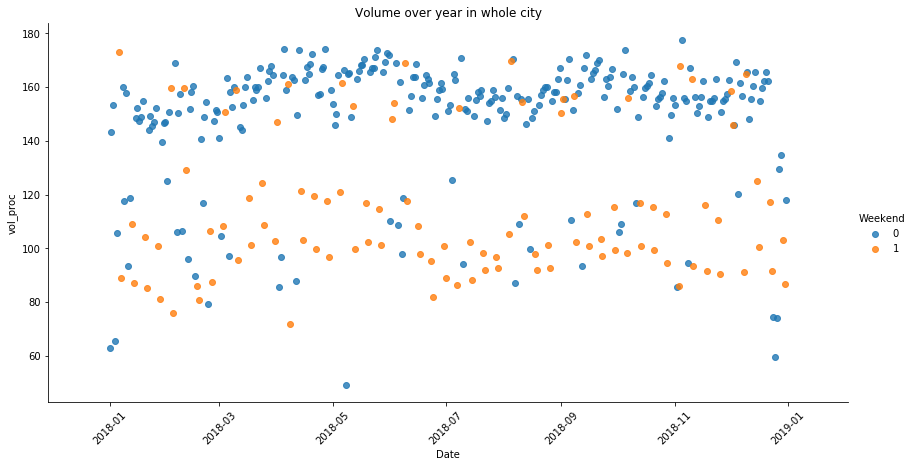

In [129]:
graph = sns.lmplot('Date', 'vol_proc', data = df_avg, fit_reg=False, hue='Weekend', height=6, aspect=2)
graph.set_xticklabels(rotation=45)
plt.title('Volume over year in whole city')

In [122]:
df_avg_monthly = df_avg.groupby('Month')['vol_proc'].mean().reset_index()

Text(0.5, 1.0, 'Transport volume each month')

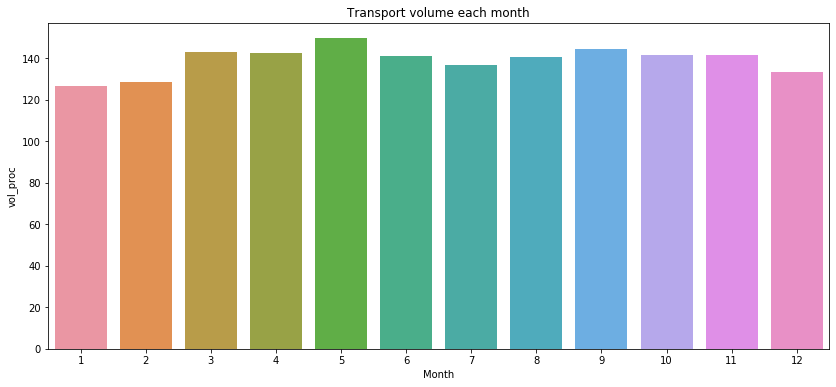

In [134]:
plt.figure(figsize=(14,6))
sns.barplot('Month','vol_proc',data=df_avg_monthly).set_title('Transport volume each month')

**1st conclusion**
From the plots above we can see that average transport volume in the whole Vilnius city tends to decrease in winter and summer and increase in spring and autumn. Most accupied month - May, least - January. Alse it is clearly noticable that transport volume during working daygs is nearly twice as big as in weekends.

## Vilnius city transport volume each hour in 2018

### Group by day

In [141]:
df_avg_hour = df[['Hour','vol_proc','occ_proc','spd_proc']].groupby('Hour').mean().reset_index()

Text(0.5, 1.0, 'Transport volume each hour')

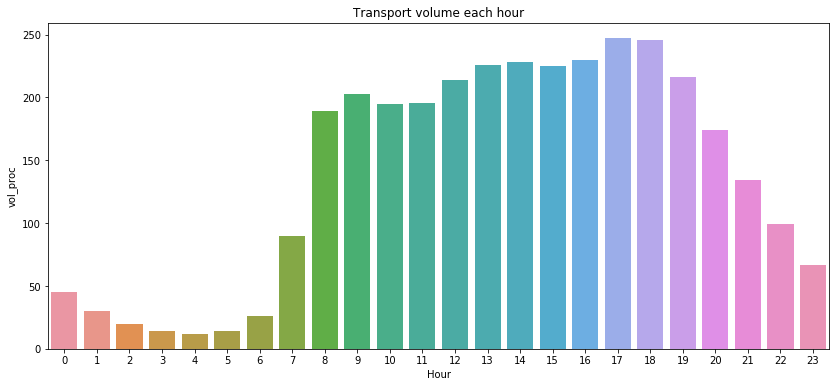

In [143]:
plt.figure(figsize=(14,6))
sns.barplot('Hour','vol_proc',data=df_avg_hour).set_title('Transport volume each hour')

**2nd conclusion**   
As can be expected during peak hours (17PM - 18PM) transport volume is biggest. Then decresing trend is noticed till 4AM. After that volume starts increasing. 

## Vilnius city transport volume during each week day

In [7]:
df = pd.read_csv('main_data_with_codes_dates_and_coordinates.csv')

In [19]:
df_avg_day = df[['Week day','vol_proc']].groupby('Week day').mean().reset_index()

Text(0.5, 1.0, 'Transport volume each day of the week')

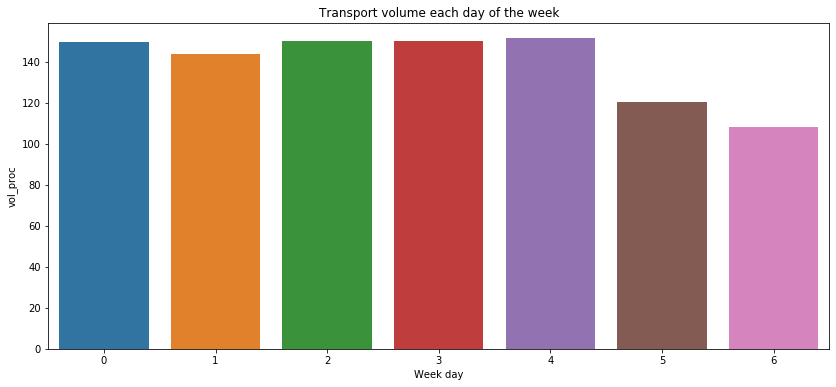

In [12]:
plt.figure(figsize=(14,6))
sns.barplot('Week day','vol_proc',data=df_avg_day).set_title('Transport volume each day of the week')

In [20]:
df_avg_day['Week end'] = df_avg_day.apply(weekends, axis=1)

In [22]:
df_avg_day = df_avg_day.groupby('Week end')['vol_proc'].mean().reset_index()

Text(0.5, 1.0, 'Transport volume each day of the week')

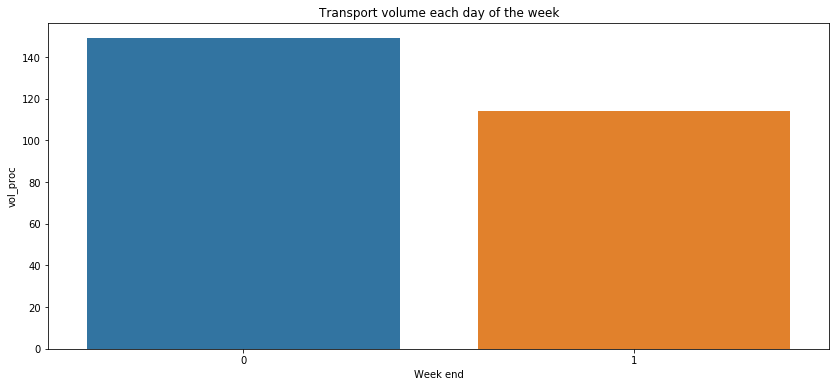

In [24]:
plt.figure(figsize=(14,6))
sns.barplot('Week end','vol_proc',data=df_avg_day).set_title('Transport volume each day of the week')

**3rd conclusion**   
As we can see during weekends (5 and 6) transport volume is much lower compared to other days(working days). Most occupied days seems are monday and friday. 

## Interactive maps

### Plot detector density

In [130]:
df_coordinates = pd.read_excel('Sankryzos_koordinatės.XLSX', sheet_name='Lapas1')

In [131]:
df_coordinates['x'] = df_coordinates.apply(format_x, axis=1)
df_coordinates['y'] = df_coordinates.apply(format_y, axis=1)

In [132]:
m_1 = folium.Map(location=[54.697964, 25.300914], tiles='cartodbpositron', zoom_start=12.5)
HeatMap(data=df_coordinates[['y', 'x']], radius=23).add_to(m_1)

In [133]:
embed_map(m_1, 'm_1.html')

**4th conclusion**   
As can be expected biggest traffic light/detectors density locates around city center.

### Plot vol_proc distribution

In [134]:
df_group_code_mean = df.groupby('Code')['vol_proc'].mean().reset_index()

In [135]:
df_coordinates['Node'] = df_coordinates.apply(get_code_coordinates, axis=1)

In [136]:
df_coordinates.rename(columns={'Node': 'Code'}, inplace=True)

In [137]:
df_coordinates['Code'] = df_coordinates['Code'].astype(int)

In [138]:
df_map = df_group_code_mean.merge(df_coordinates, on='Code', how='left')

In [142]:
df_map = df_map.dropna()

In [143]:
df_map

,Code,vol_proc,x,y
0,101,178.878025,25.279870,54.690814
1,102,216.736442,25.276525,54.691038
2,103,238.133280,25.273410,54.691588
3,104,136.800074,25.271703,54.692274
4,105,111.848687,25.270295,54.691222
...,...,...,...,...
230,1065,125.541273,25.280043,54.752435
231,1066,172.016830,25.228338,54.716553
232,1070,189.411200,25.304856,54.711292
233,1072,127.238211,25.411414,54.688383


In [144]:
m_2 = folium.Map(location=[54.690814, 25.279870], tiles='cartodbpositron', zoom_start=20)
for i in range(0,len(df_map)):
    folium.Circle(
        location=[df_map.iloc[i]['y'], df_map.iloc[i]['x']],
        radius=(df_map.iloc[i]['vol_proc']/6)**1.5,
        color=color_producer(df_map.iloc[i]['vol_proc'])).add_to(m_2)

**Circle radius is proportional to transport volume in that crossroad.**  
Green - low volume  
Orange - medium volume  
Green - big volume  
Blue - very big volume  

In [145]:
embed_map(m_2, 'q_2.html')

**5th conclusion**
From above interactive map we can see that biggest traffic volume tends to appear in Antakalnis street, around city center. One of the biggest circle locates in Ozas street from Valakampis bridge. It tells that one of the biggest transport transparency appears there, Darius ir Gireno street as well.